# AI Workshop - Lab 2-2: Intent Classification

In this lab, we’ll build a system to classify customer text messages into different categories (called **intents**) using a powerful type of AI model called a transformer. Transformers are a key technology behind tools like ChatGPT and other modern language systems, but don’t worry if you’re new to them—we’ll break it down step by step.

### Data Overview

We’re working with a dataset of customer text messages that has already been labeled with their intent (e.g., "Order Status", "Product Inquiry", "Account Help"). The goal is to teach the model to recognize these patterns so it can classify new messages correctly.

- **Dataset**:
  - Provided as two files: one for training and one for testing.
  - Training data is used to teach the model, and testing data is used to see how well it learned.
- **Number of Categories**: 27 different intents.

### What We’ll Do in This Lab
1. **Load the Data**:
   - Open and inspect the dataset to understand its structure.
   - Check how many examples we have for each intent.
2. **Prepare the Data**:
   - Use a tool called a **tokenizer** to break down text messages into a format the model can understand.
   - Convert the intent labels into numbers so the model can learn from them.
3. **Use a Pre-Trained Model**:
   - Start with an existing model called `T5-small` that already knows a lot about language.
   - Customize (or fine-tune) it to focus on the intents in our dataset.
4. **Train the Model**:
   - Use the prepared data to train the model step by step.
   - Measure how well it’s doing along the way.
5. **Evaluate the Model**:
   - Test the model on new data it hasn’t seen before.
   - Check how accurate it is and where it might make mistakes.

### What You’ll Learn
- **Transformers**: Get an introduction to these models and why they’re so powerful for language tasks.
- **Fine-Tuning**: Learn how to take a pre-trained model and adapt it to solve a specific problem.
- **Model Evaluation**: Understand how to measure a model’s performance and interpret its predictions.

### HuggingFace Libraries

So far we have been working with Keras, a popular library for building neural networks. In this lab, we’ll use the HuggingFace libraries, which are designed specifically for working with transformers.

The main HuggingFace library is called `transformers`, and it provides tools for working with pre-trained models, tokenizers, and training pipelines. We’ll also use `datasets` to load and process our data. `accelerate` and `evaluate` are additional libraries that help speed up training and evaluate models, respectively. Install them below:

In [1]:
!pip install -Uq datasets transformers accelerate evaluate

For this lab, it's essential that we have a GPU available to speed up training. On Google Colab, you can enable a GPU by going to **Runtime** > **Change runtime type** > **Hardware accelerator** > **GPU**.

The following line of code will check if a GPU is available:

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU is available!')
else:
    print('GPU is not available. Enable a GPU runtime in Colab under "Runtime" > "Change runtime type".')

GPU is available!


### Loading the Dataset

Now that we’ve set up our environment and imported the necessary packages, let’s begin by loading our dataset.

In this lab, we’ll work with a dataset of **customer text messages** that have been labeled with their **intent**. Each sample in the dataset includes a text message and a corresponding label indicating the intent behind the message (e.g., inquiry, complaint, order request). This dataset will allow us to build and evaluate models for intent classification.

#### Steps:
1. **Load the Dataset**:
   - Use the `load_dataset` function from the `datasets` library to download and load the dataset.
   - The dataset we’re using is hosted at `"alexwaolson/customer-intents"`.
2. **Inspect the Dataset**:
   - After loading, examine the training split (`intents['train']`) to understand its structure and the data it contains.

In [3]:
from datasets import load_dataset

# Load the customer intents dataset
intents = load_dataset("alexwaolson/customer-intents")

# Display the training split
intents['train']

Dataset({
    features: ['message', 'label'],
    num_rows: 1555
})

The dataset consists of two key columns:
- **`message`**: Contains the text of the customer message.
- **`label`**: Contains the intent category for each message.

There are **27 possible intent categories** in this dataset. To understand the distribution of these categories, we can count the number of examples for each intent. This helps us determine whether the dataset is balanced (i.e., whether all categories have similar representation) or imbalanced (some categories have significantly more or fewer samples than others).

Run the code below to calculate the distribution of intent labels:

Number of unique intents: 27


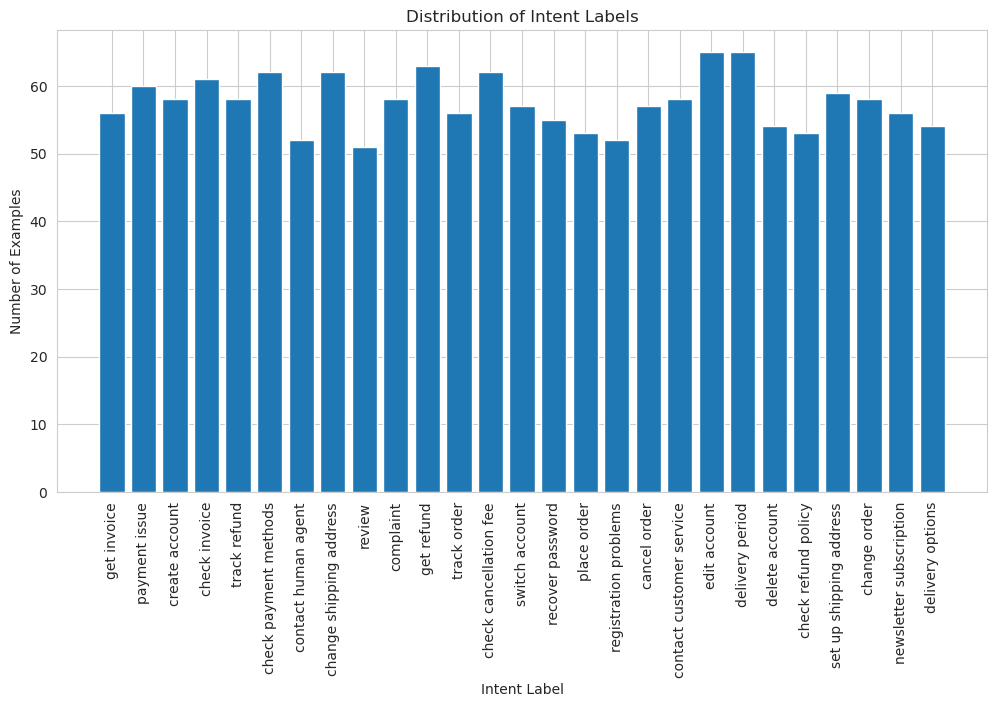

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each intent label in the training data
label_counts = Counter(intents['train']['label'])
print(f'Number of unique intents: {len(label_counts)}')

# Plot the distribution of intent labels
plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Intent Label')
plt.ylabel('Number of Examples')
plt.title('Distribution of Intent Labels')
plt.xticks(rotation=90)
plt.show()

## Preprocessing the Dataset

Now that our dataset is loaded, we need to prepare it for training. This involves several steps, including tokenization, padding, and setting up a data collator. These steps ensure that the raw text data is transformed into a format that our model can understand and process efficiently.

### Tokenization

Most language models, including T5, don't work directly with raw text but with **tokenized inputs**. Tokenization involves breaking down text into smaller units, called **tokens**, which are then converted into numerical IDs that the model can process.

#### How Tokenization Works:
1. **Splitting Text**:
   - Text is split into words, subwords, or characters.
   - For example, the word "running" might be split into "run" and "##ning" (where `##` indicates a suffix).
2. **Mapping to IDs**:
   - Each token is mapped to a unique integer ID using a vocabulary associated with the tokenizer.
3. **Flexibility**:
   - This approach allows the model to understand the meaning of individual components (like "run" and "-ning") and combine them to interpret words.

#### Why Tokenization is Important:
- It converts raw text into numerical data that can be used for deep learning.
- It helps the model generalize to unseen words by breaking them into familiar components.

#### T5 Model and Tokenizer:
We’ll use the `AutoTokenizer` class from the `transformers` library to load a tokenizer that matches the **T5-small** model. T5 (Text-to-Text Transfer Transformer) is a versatile language model designed to handle a wide range of NLP tasks by treating all tasks as text-to-text transformations.

Let's load the tokenizer and inspect its properties:

In [5]:
from transformers import AutoTokenizer

# Load our tokenizer
model_name = 't5-small'
# The AutoTokenizer class will automatically select the correct tokenizer class for the model!
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Inspecting the Tokenizer

Before we start using the tokenizer to preprocess our dataset, let’s take a closer look at its capabilities. Understanding the tokenizer’s vocabulary and special tokens will help us use it effectively.

#### Vocabulary Size
The tokenizer’s **vocabulary size** represents the total number of unique tokens it can recognize and map to IDs. This includes:
- Words
- Subwords
- Special tokens

A larger vocabulary allows the model to understand a wider range of text but may also increase the computational requirements.

#### Special Tokens
Special tokens are reserved tokens used for specific purposes in a model:
- **Start and End Tokens**: Indicate the beginning and end of sequences.
- **Padding Token**: Ensures all sequences in a batch have the same length by filling shorter sequences.
- **Other Tokens**: For tasks like separating sentences or marking different segments in the input.

In [6]:
# Inspect the tokenizer's vocabulary and special tokens
print(f'Vocab size:     {tokenizer.vocab_size} tokens')  # Total number of tokens in the vocabulary
print(f'End token:      {tokenizer.eos_token}')          # End of sequence token
print(f'Padding token:  {tokenizer.pad_token}')          # Padding token
print(f'Unknown token:  {tokenizer.unk_token}')          # Unknown token, for out-of-vocabulary words

Vocab size:     32100 tokens
End token:      </s>
Padding token:  <pad>
Unknown token:  <unk>


The tokenizer not only converts text into token IDs but can also convert token IDs back into text. This process involves:
- **Encoding**: Breaking a string into tokens and mapping them to unique IDs.
- **Decoding**: Converting token IDs back into a human-readable string.

To better understand how tokenization works, we’ll use a custom function, `show_tokenization`, which:
1. Displays the original text.
2. Encodes the text into token IDs.
3. Decodes each token ID back into its corresponding token.

#### **Your Turn**:
- Write a sentence in the `show_tokenization` function to see how it is tokenized by the model.
- Try using:
  - A sentence with common words.
  - A sentence containing made-up words.
  - Words that might be split into multiple tokens (e.g., "unbelievably").

In [7]:
def show_tokenization(tokenizer, text):
    print(f'Original text: {text}')
    tokens = tokenizer(text, truncation=True)['input_ids']
    for token in tokens:
        print(f'{tokenizer.decode([token]):10} -> {token}')

# Write a sentence to see how it gets tokenized:
show_tokenization(tokenizer, 'your sentence here')

Original text: your sentence here
your       -> 39
sentence   -> 7142
here       -> 270
</s>       -> 1


### Tokenizer Basics: Padding and Attention Masks

Now that you’ve seen how tokenization works, let’s cover a few additional concepts: **attention masks** and **padding**. These concepts are crucial for processing variable-length sequences when training models.

#### Attention Mask
- The **attention mask** is a vector that tells the model which tokens are actual input and which are padding.
- For example:
  - A token with a mask value of `1` indicates that it is part of the original input.
  - A token with a mask value of `0` indicates that it is a padding token and should be ignored during processing.

You may see this term pop up later when preparing data for the model.

#### Padding
When training models in batches, all sequences in a batch must have the same length to allow parallel processing. Since sequences vary in length, we:
1. Add **padding tokens** to the shorter sequences to make them the same length as the longest sequence in the batch.
2. Use the attention mask to ensure the model ignores these padding tokens during training.

##### Example:
If a batch has a maximum length of 10 tokens and a sequence like `"Hello, world!"` (with 2 tokens) is in the batch:

- **Original**: `"Hello, world!"`
- **Padded**: `"<pad>, "Hello", ",", "world", "!", </s>, <pad>, <pad>, <pad>, <pad>"`
- **Attention Mask**: `[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]`

#### Setting Maximum Length
By default, the T5-small model expects sequences of up to 512 tokens. However, for this task, we don’t need sequences that long. We’ll set the maximum sequence length to **40 tokens**. This ensures:
- Sequences longer than 40 tokens are truncated.
- Shorter sequences are padded to reach 40 tokens.

Run the following code to configure the tokenizer:

In [8]:
# Define maximum sequence length for inputs
max_input_length = 40

# Set the tokenizer's maximum length
tokenizer.model_max_length = max_input_length

### Handling Long Sequences: Truncation

When input sequences exceed the specified maximum length, the tokenizer will **truncate** them to fit. Truncation simply means cutting off tokens that exceed the limit, and this can be done either from the start (left truncation) or the end (right truncation) of the sequence.

#### Truncation Options
- **Right Truncation** (default): Removes tokens from the end of the sequence.
- **Left Truncation**: Removes tokens from the start of the sequence.

The choice between left or right truncation depends on the task:
- For summarization or text generation, keeping the start of the text (left truncation) might not make sense since context at the end is often important.
- For tasks like sentence classification, keeping the start (right truncation) may suffice if the relevant information is typically in the first part of the text.

#### **Your Turn**:
1. Use the cell below to input a long sentence and observe how the tokenizer truncates it.
2. Experiment by changing:
   - `truncation_side` to `'left'` or `'right'` to see how truncation behaves.
   - The `max_input_length` to control the maximum allowed tokens for input sequences.

In [9]:
# Set truncation behavior
tokenizer.truncation_side = 'right'  # Truncate from the end
# tokenizer.truncation_side = 'left'  # Uncomment to truncate from the start

# Test the tokenizer with a long sentence
show_tokenization(tokenizer, "write a REALLY long sentence in here and see what happens")

Original text: write a REALLY long sentence in here and see what happens
write      -> 1431
           -> 3
a          -> 9
REAL       -> 17833
LY         -> 5121
long       -> 307
sentence   -> 7142
in         -> 16
here       -> 270
and        -> 11
see        -> 217
what       -> 125
happens    -> 2906
</s>       -> 1


### Preparing the Dataset for Training

Now that we’ve configured the tokenizer, the final step before training is to **preprocess the data**. This involves tokenizing the text messages in our dataset so they are converted into token IDs and ready for the model to process.

#### Defining a Preprocessing Function
We’ll define a function, `preprocess_function`, to handle this tokenization. The function will:
1. Take a batch of examples from the dataset.
2. Use the tokenizer to tokenize the `message` field, with truncation enabled to handle sequences longer than the maximum allowed length.

Here’s the function:

In [10]:
def preprocess_function(examples):
    return tokenizer(examples["message"], truncation=True)

### Tokenizing the Dataset

The map method is used to apply the preprocess_function to each batch of examples in the dataset:

- Setting `batched=True` ensures that the function processes multiple examples at once, making it more efficient.
- The tokenized output will include token IDs and attention masks for each example.

Run the following code to tokenize the dataset:

In [11]:
tokenized_intents = intents.map(preprocess_function, batched=True)

In [12]:
tokenized_intents['train']

Dataset({
    features: ['message', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1555
})

### Data Collation

Before training our model, we need to handle one last preprocessing step: **data collation**. This involves combining individual examples into batches that the model can process efficiently. During collation:
- All sequences in a batch are padded to the same length to ensure uniformity.
- The resulting batch is formatted into a structure compatible with the model.

#### Setting Up a Data Collator
We’ll use the `DataCollatorWithPadding` class from the `transformers` library. This class:
- Uses the tokenizer to handle padding.
- Returns the collated batch as PyTorch tensors (`return_tensors="pt"`).


In [13]:
from transformers import DataCollatorWithPadding

# Create a data collator for padding and batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

### Evaluation Metric

During training, we need a way to evaluate the model's performance. We'll compute metrics like **accuracy** to measure how well the model's predictions match the true labels. This will help us monitor progress and identify areas for improvement.

#### Setting Up the Metric
We'll use the `evaluate` library to calculate accuracy. To do this, we define a function called `compute_metrics`, which processes the model's predictions and computes the desired metric.

In [14]:
import evaluate
import numpy as np

# Load the accuracy metric
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    # Unpack predictions and labels
    predictions, labels = eval_pred.predictions, eval_pred.label_ids

    # Handle tuple predictions (e.g., logits)
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Use the logits

    # Convert predictions to a NumPy array if necessary
    predictions = np.array(predictions)

    # Compute class predictions (argmax for classification)
    predictions = np.argmax(predictions, axis=1)

    # Return the computed accuracy
    return accuracy.compute(predictions=predictions, references=labels)

### Encoding Labels

To train our model, we need to convert the **intent labels** into numerical values. Machine learning models work with numbers, not text, so we’ll create a mapping that translates each text label into a unique integer. This process is known as **label encoding**.

#### Steps:
1. **Create a Mapping**:
   - `label2id`: Maps each label (text) to a unique integer.
   - `id2label`: Provides the reverse mapping, converting integers back to labels for easy interpretation later.
2. **Apply the Mapping**:
   - Use the `map` function to encode the `label` field in the dataset, replacing text labels with their corresponding integers.

In [15]:
# Create mappings from labels to integers and vice versa
label2id = {label: i for i, label in enumerate(intents['train'].unique('label'))}
id2label = {i: label for label, i in label2id.items()}

# Function to encode labels
def encode_label(example):
    example['label'] = label2id[example['label']]
    return example

# Apply the label encoding to the dataset
tokenized_intents = tokenized_intents.map(encode_label)

# Inspect the encoded training dataset
tokenized_intents['train']

Dataset({
    features: ['message', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1555
})

### Loading the Model

With our data preprocessed, it's time to load the **pre-trained model** that we’ll fine-tune for our classification task. Pre-trained models are powerful because they already have a general understanding of language, allowing us to focus on adapting them to our specific problem.

#### Model Setup
We’ll use the `AutoModelForSequenceClassification` class from the `transformers` library to load a model designed for sequence classification tasks. This class:
- Loads a pre-trained model for tasks where the input is a sequence (e.g., text) and the output is a classification label.
- Automatically configures the model for the number of classes (27 intent categories in our case).

#### Key Parameters:
- **Pre-trained Model**: We’re using `t5-small`, a small but capable version of the T5 model, designed for efficient fine-tuning.
- **Number of Labels**: `num_labels=27` specifies the number of intent categories in our dataset.
- **Label Mappings**: `id2label` and `label2id` ensure that the model can interpret numeric labels and translate them back into text labels when needed.

When you run the code to load the model, you’ll likely see a warning message like this:
```
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight'] You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```
This message is expected because we haven’t trained the model yet. It’s a reminder that the model’s classification head (the part responsible for classifying sequences) is initialized randomly and needs to be trained on our dataset.

In [16]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "t5-small",         # Model name
    num_labels=27,      # Number of intent categories
    id2label=id2label,  # Mapping from IDs to labels
    label2id=label2id   # Mapping from labels to IDs
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

We’re now ready to train our model! The `Trainer` class from the `transformers` library simplifies the training process by handling key tasks like batching, evaluation, and gradient updates. To customize the training, we define a set of **training arguments** that specify how the training should proceed.

#### Training Arguments Explained:
- **`per_device_train_batch_size`**: The number of samples processed at once on each device (e.g., GPU). Smaller batch sizes may be necessary if memory is limited.
- **`per_device_eval_batch_size`**: Similar to the training batch size but used for evaluation.
- **`num_train_epochs`**: The number of passes through the entire training dataset.
- **`logging_dir`**: Directory where training logs are saved for monitoring.
- **`logging_steps`**: How often (in steps) training progress is logged.
- **`eval_strategy`**: Specifies when evaluation is performed. Here, it’s set to evaluate every few steps.
- **`eval_steps`**: The number of steps between evaluations.
- **`save_strategy`**: Determines when the model is saved. Here, saving is disabled with `"no"`.
- **`output_dir`**: Directory where final model files and outputs will be saved. This is required even if saving is disabled.

#### Setting Up the Trainer
The `Trainer` class brings everything together:
- **Model**: The model to be trained.
- **Arguments**: The training configuration (`training_args`).
- **Datasets**: The preprocessed training and evaluation datasets.
- **Data Collator**: Handles batching and padding during training.
- **Metrics**: The `compute_metrics` function for evaluating performance.

In [17]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=8,    # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    num_train_epochs=3,              # Number of training epochs
    logging_dir='logs',              # Directory for logs
    logging_steps=10,                # Log progress every 10 steps
    eval_strategy="steps",           # Evaluate every X steps
    eval_steps=10,                   # Perform evaluation every 10 steps
    save_strategy="no",              # Disable model saving
    output_dir='output'              # Directory for output files
)

# Set up the Trainer
trainer = Trainer(
    model=model,                     # Model to train
    args=training_args,              # Training arguments
    train_dataset=tokenized_intents['train'],  # Training dataset
    eval_dataset=tokenized_intents['test'],    # Evaluation dataset
    data_collator=data_collator,     # Handles padding and batching
    compute_metrics=compute_metrics  # Evaluates model performance
)

# Start training
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,3.228000,3.351295,0.041131
20,3.424200,3.314425,0.043702
30,3.327000,3.277397,0.061697
40,3.273300,3.251352,0.089974
50,3.295700,3.229980,0.113111
60,3.289600,3.216614,0.113111
70,3.279400,3.198606,0.084833
80,3.253200,3.179330,0.079692
90,3.213200,3.156933,0.125964
100,3.219300,3.130916,0.174807


TrainOutput(global_step=585, training_loss=2.851092356494349, metrics={'train_runtime': 64.6493, 'train_samples_per_second': 72.159, 'train_steps_per_second': 9.049, 'total_flos': 20767034735856.0, 'train_loss': 2.851092356494349, 'epoch': 3.0})

### Evaluating the Model

After training, it’s time to evaluate the model's performance on the **test dataset**, which contains unseen examples. This allows us to measure how well the model generalizes to new data.

#### Current Performance
- After a few epochs of training, the model achieves around **55% accuracy**. While this is a good start, it suggests there’s room for improvement with additional tuning and training.
- Remember, with 27 intent categories, random guessing would yield an accuracy of ~3.7%, so 55% represents a significant improvement.

#### Evaluation Tools
To better understand the model's strengths and weaknesses, we’ll:
1. **Generate a Classification Report**:
   - The classification report provides metrics like precision, recall, and F1-score for each intent category.
   - This helps identify which categories the model performs well on and which are more challenging.
2. **Produce a Confusion Matrix**:
   - The confusion matrix shows how often each category is confused with others.
   - It helps identify specific pairs of intents that the model struggles to distinguish.

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Get predictions on the test dataset
predictions = trainer.predict(tokenized_intents['test']).predictions[0]

# Compute class predictions
class_predictions = np.argmax(predictions, axis=1)

# Get true labels
true_labels = tokenized_intents['test']['label']

# Convert labels to text
true_labels_text = [id2label[label] for label in true_labels]
predicted_labels_text = [id2label[label] for label in class_predictions]

# Display classification report
report = pd.DataFrame(classification_report(true_labels_text, predicted_labels_text, output_dict=True, zero_division=0)).T
report

,precision,recall,f1-score,support
cancel order,0.285714,1.000000,0.444444,14.000000
change order,0.200000,0.055556,0.086957,18.000000
change shipping address,0.350000,0.875000,0.500000,8.000000
check cancellation fee,0.846154,1.000000,0.916667,11.000000
check invoice,0.437500,0.538462,0.482759,13.000000
check payment methods,0.520000,1.000000,0.684211,13.000000
check refund policy,0.000000,0.000000,0.000000,16.000000
complaint,0.722222,1.000000,0.838710,13.000000
contact customer service,1.000000,0.909091,0.952381,11.000000
contact human agent,0.952381,1.000000,0.975610,20.000000


### Visualizing the Confusion Matrix

The **confusion matrix** provides a detailed view of the model's performance by showing how often each category is predicted correctly or confused with others. It’s a square matrix where:
- Rows represent the **true labels**.
- Columns represent the **predicted labels**.

#### How to Interpret the Confusion Matrix:
- Each cell \((i, j)\) shows the number of examples with true label \(i\) that were predicted as label \(j\).
- **Diagonal values**: Represent correct predictions (true label matches predicted label).
- **Off-diagonal values**: Represent misclassifications, highlighting categories that are commonly confused.

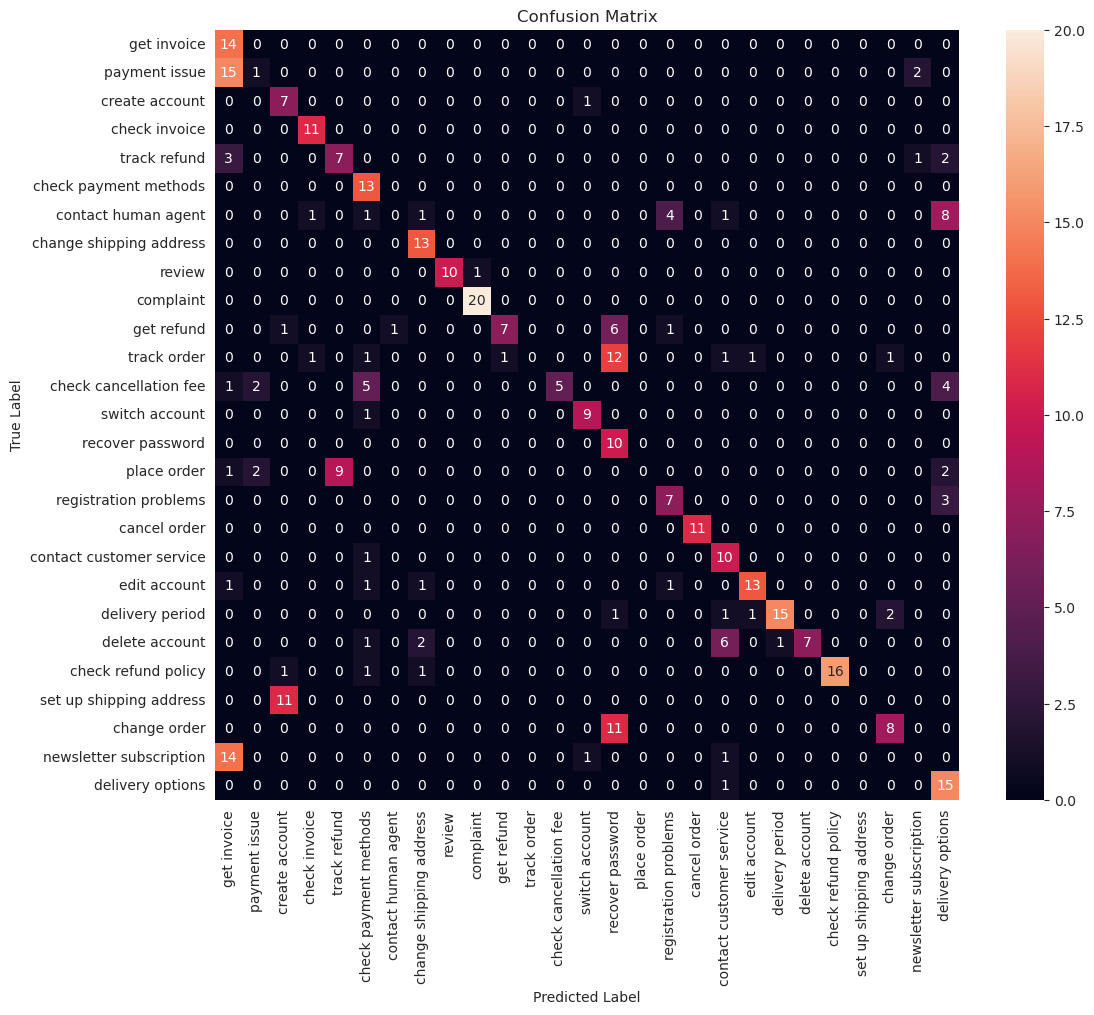

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels_text, predicted_labels_text)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Model in Practice

In real-world applications, a model like this can be used to automatically classify customer messages. However, it's often important to account for uncertainty in the model's predictions. For example:
- If the model is **confident**, the predicted intent can be used directly.
- If the model's **confidence is low**, the message can be flagged for manual review, with the top predicted intents provided to assist human agents.

#### Implementing a Practical Prediction Method
We’ll write a method, `predict_intent`, that:
1. **Classifies Messages**:
   - Predicts the most likely intent for each message.
2. **Handles Uncertainty**:
   - If the model’s confidence (probability of the top prediction) is below a specified threshold, it returns the top 3 most likely intents instead of a single prediction.

In [30]:
def predict_intent(model, tokenizer, messages, id2label, threshold=0.5):
    # Tokenize the messages
    tokenized_messages = tokenizer(messages, truncation=True, padding=True, return_tensors="pt").to(device)

    model.to(device)

    # Get model predictions
    predictions = model(**tokenized_messages)

    # Get logits as numpy array for processing
    logits = predictions.logits.detach().cpu().numpy()

    # Get predicted class
    predicted_class = np.argmax(logits, axis=1).tolist()

    # Get predicted probabilities
    predicted_probs = np.max(logits, axis=1).tolist()

    # Get predicted labels
    predicted_labels = [id2label[label] for label in predicted_class]

    # Get top intents if confidence is low
    if any(prob < threshold for prob in predicted_probs):
        top_intents = [
            [id2label[i] for i in np.argsort(logit)[::-1][:3]]
            for logit in logits
        ]
        return top_intents[0]
    else:
        return predicted_labels[0]

for message in intents['test']['message'][0:15]:
    print(f"Message: {message}")
    print(f"Predicted Intent: {predict_intent(model, tokenizer, message, id2label)}")
    print()

Message: I do not know how I can get the bill from Anna Freeman


ValueError: You have to specify either decoder_input_ids or decoder_inputs_embeds

### Zero-Shot Learning

One of the most powerful features of large language models is their ability to perform **zero-shot learning**. Unlike traditional models that require task-specific training, a zero-shot learning model can classify text based on its general understanding of language, even if it hasn’t been explicitly trained on that specific task.

#### How It Works:
- Instead of fine-tuning the model, you provide it with a **prompt** that describes the task and possible labels (e.g., "What is the intent of this message?").
- The model uses its pre-trained knowledge to predict the most appropriate label.

This approach leverages the model's extensive training on a wide variety of text, making it flexible for many tasks.

#### Why Use Zero-Shot Learning?
- **Quick Prototyping**: No need to preprocess or fine-tune the model for every new task.
- **Versatility**: Works for tasks the model wasn’t explicitly trained on, as long as the task can be described in a prompt.

#### Using a Larger Model:
For zero-shot classification, we’ll use the `flan-t5-large` model, which is better suited for this task due to its size and broader understanding of language. Since this model doesn’t require fine-tuning, we can focus on testing its performance directly.

#### Installation:
The `sentencepiece` library is required to use the `flan-t5-large` model. Install it by running the following command:

In [21]:
!pip install sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Zero-Shot Intent Classification with Flan-T5

We’ll now use the **Flan-T5 large** model to classify intents via zero-shot learning. This approach involves crafting a **prompt** that describes the task and provides the model with the possible labels. The model then uses its language understanding to predict the intent without task-specific training.

#### Prompt Construction
The prompt is key to zero-shot learning. For our task:
1. The prompt begins by instructing the model to classify the intent of the message.
2. It lists the available intent categories.
3. Finally, it appends the message to classify.

In [32]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="cuda" if torch.cuda.is_available() else "cpu")

# Define the prompt
prompt = "Classify the intent of the following message using these categories:\n"
for label in id2label.values():
    prompt += f"- {label}\n"
prompt += "Message: "

print(prompt)

# Function for zero-shot classification
def zero_shot_intent_classification(model, prompt, message):
    # Combine the prompt and the message
    input_text = prompt + message
    # Tokenize the input text
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # Generate a prediction
    output = model.generate(input_ids, max_length=50, num_beams=5, early_stopping=True)
    # Decode the prediction into text
    return tokenizer.decode(output[0], skip_special_tokens=True)

Classify the intent of the following message using these categories:
- get invoice
- payment issue
- create account
- check invoice
- track refund
- check payment methods
- contact human agent
- change shipping address
- review
- complaint
- get refund
- track order
- check cancellation fee
- switch account
- recover password
- place order
- registration problems
- cancel order
- contact customer service
- edit account
- delivery period
- delete account
- check refund policy
- set up shipping address
- change order
- newsletter subscription
- delivery options
Message: 


### Testing Zero-Shot Intent Classification

You can now test the zero-shot classification capabilities of the `flan-t5-large` model on a subset of messages from the test set. This will provide a sense of how well the model performs without task-specific training.

In [33]:
for message in intents['test']['message'][25:35]:
    print(f"Message: {message}")
    print(f"Predicted Intent: {zero_shot_intent_classification(model, prompt, message)}")
    print()

Message: delete Gold account
Predicted Intent: delete account

Message: I am trying to unsubscribe to the newsletter
Predicted Intent: newsletter subscription

Message: what do I need to do to change to the free account?
Predicted Intent: switch account

Message: open anotherstandard account
Predicted Intent: create account

Message: I'd like to switch to the damn Premium account how to do it
Predicted Intent: switch account

Message: editing standard account
Predicted Intent: edit account

Message: wanna order several items help me
Predicted Intent: place order

Message: problems with standard account terminations
Predicted Intent: contact customer service

Message: want help ti earn some of ur product
Predicted Intent: place order

Message: I need help notifying of a trouble with online payment
Predicted Intent: payment issue



### Evaluating Zero-Shot Model Performance on the Test Dataset

To evaluate the performance of the `flan-t5-large` zero-shot model on the entire test dataset, we’ll:
1. **Generate Predictions**: Use the `zero_shot_intent_classification` function to predict intents for all test messages.
2. **Compare Predictions**: Compare the zero-shot predictions to the true labels in the test set.
3. **Generate a Classification Report**: Use `classification_report` to compute metrics such as precision, recall, and F1-score for each intent category.

In [26]:
from tqdm import tqdm
from sklearn.metrics import classification_report
import pandas as pd

# Generate predictions for the test dataset using the zero-shot model
zero_shot_predictions = [
    zero_shot_intent_classification(model, prompt, message)
    for message in tqdm(intents['test']['message'])
]

# Create a classification report
zero_shot_report = pd.DataFrame(
    classification_report(true_labels_text, zero_shot_predictions, output_dict=True, zero_division=0)
).T

# Display the report
zero_shot_report

100%|██████████| 389/389 [00:53<00:00,  7.23it/s]


,precision,recall,f1-score,support
cancel order,0.750000,0.642857,0.692308,14.000000
change order,1.000000,0.500000,0.666667,18.000000
change shipping address,0.275862,1.000000,0.432432,8.000000
check cancellation fee,1.000000,0.727273,0.842105,11.000000
check invoice,1.000000,0.461538,0.631579,13.000000
check payment methods,1.000000,1.000000,1.000000,13.000000
check refund policy,0.789474,0.937500,0.857143,16.000000
complaint,1.000000,0.538462,0.700000,13.000000
contact customer service,0.160000,0.727273,0.262295,11.000000
contact human agent,0.740741,1.000000,0.851064,20.000000


Incredibly, our accuracy using zero-shot learning is around **70%**, which is significantly higher than our fine-tuned model! This demonstrates the power of large language models and their ability to generalize to new tasks without explicit training.


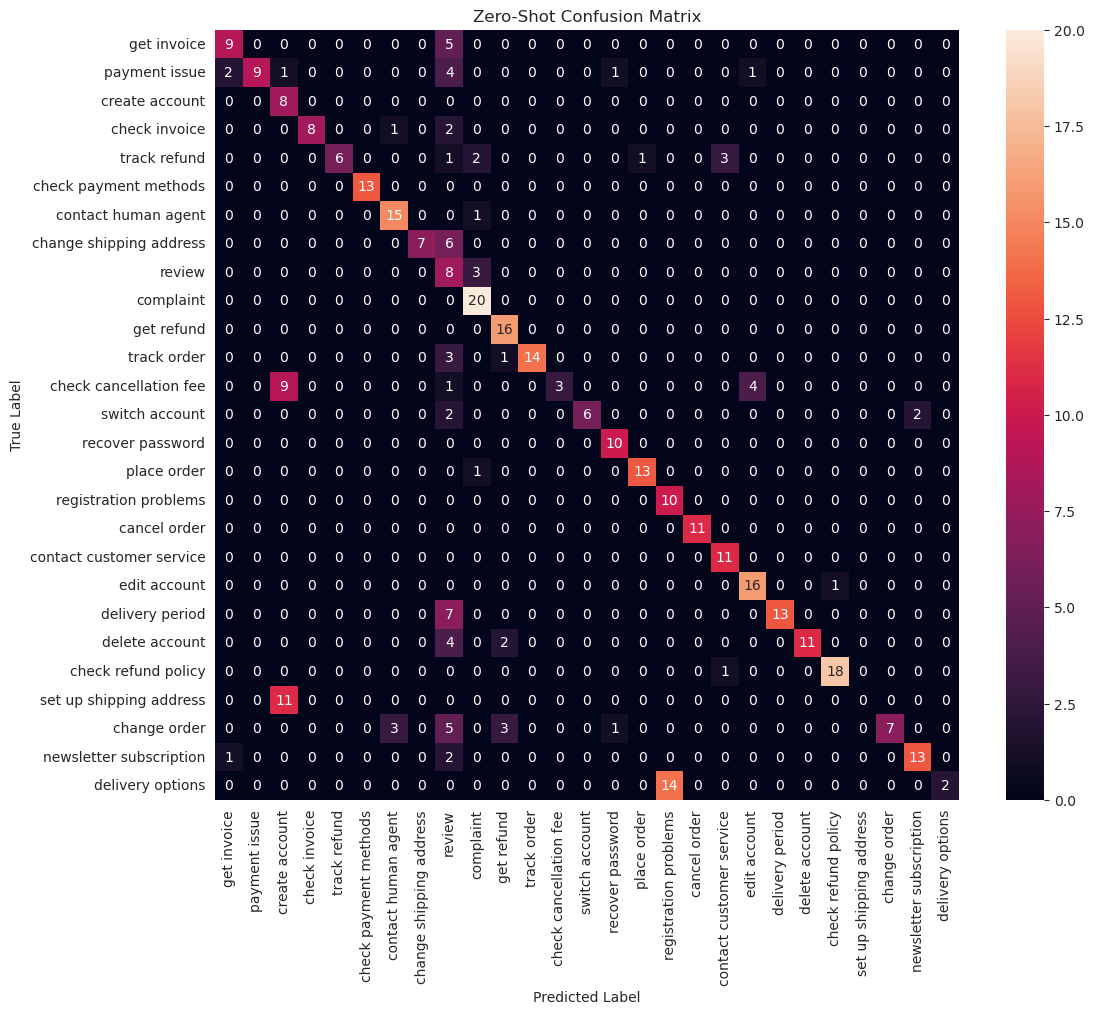

In [35]:
# Confusion Matrix

# Compute confusion matrix
zero_shot_conf_matrix = confusion_matrix(true_labels_text, zero_shot_predictions)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(zero_shot_conf_matrix, annot=True, fmt='d', xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Zero-Shot Confusion Matrix')
plt.show()

### Conclusion

In this lab, you explored how to classify customer text messages into different intent categories using both a **fine-tuned model** and a **zero-shot learning approach**. Along the way, you learned about key concepts in NLP and machine learning, such as tokenization, data preprocessing, and evaluation metrics.

#### Key Takeaways:
1. **Fine-Tuning with Transformers**:
   - You fine-tuned the `T5-small` model for intent classification.
   - By adapting a pre-trained model, you achieved an accuracy of around **55%** after training, which is a significant improvement over random guessing (~3.7% accuracy for 27 classes).

2. **Understanding Model Predictions**:
   - You evaluated the model’s predictions using metrics like precision, recall, and F1-score, and visualized the results with a confusion matrix.
   - You implemented a method to handle uncertainty, ensuring the model flagged low-confidence predictions for manual review.

3. **Zero-Shot Learning**:
   - Using the `flan-t5-large` model, you explored the power of zero-shot learning, achieving an impressive accuracy of around **70%** without any task-specific training.
   - This highlighted the flexibility and capability of large language models to generalize across tasks.

#### Real-World Implications:
- The methods you practiced in this lab can be applied to automate tasks like customer service classification, intent detection in chatbots, or filtering messages for human review.
- Zero-shot learning offers a quick way to prototype solutions when labeled data is scarce, while fine-tuning allows for highly customized and accurate models with enough training data.